In [116]:
import os
import PIL
import math
import wandb
import torch
import hydra
import enchant
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

import straug.blur as blur
import straug.warp as warp
import straug.noise as noise
import straug.camera as camera
import straug.process as process
import straug.geometry as geometry

from tkinter import *
from torch import Tensor
from tabulate import tabulate
from tqdm.notebook import tqdm
from typing import Union, Optional
from IPython.display import display
from hydra import initialize, compose
from PIL import Image, ImageTk, ImageDraw
from pytorch_lightning import seed_everything
from ctc_decoder import best_path, beam_search
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from torchmetrics import CharErrorRate, WordErrorRate
from omegaconf import OmegaConf, DictConfig, open_dict

seed_everything(0, True)
DEVICE = 'cuda:0'

Global seed set to 0


# Dataset class

In [117]:
class HWTDataset(Dataset):
    """
    Class for creating custom image2label dataset from folder

    Args:
        Dataset (Dataset): Standart torch class for custom datasets
    """
    
    
    def __init__(
        self,
        root_dir: str,
        label_dir: str,
        transforms: transforms.Compose = None) -> None:
        
        super(HWTDataset, self).__init__()
        
        # Loading labling file
        name_label = pd.read_csv(label_dir, delimiter='\t', names = ['Image name', 'Label'])
        name_label['Image name'] = name_label['Image name'].apply(lambda x: os.path.join(root_dir, x))
        self.data = name_label.to_dict('split')['data']
        
        self.transforms = transforms
    
    
    def __len__(self) -> int:
        return len(self.data)
    
        
    def __getitem__(self, index: int) -> tuple[Tensor, str]:
        
        path, label = self.data[index]
        img = Image.open(path).convert('RGB')
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, label

# Decoder class

In [118]:
class SymbolCoder:
    """
    Class needs to encode initial phrases to Tensor
    and decode predicted labels to phrases
    """
    
    def __init__(self, alphabet) -> None:
        
        self.alphabet = ''.join(sorted(alphabet))
        self.sym2class, self.class2sym = {'' : 0}, {0 : ''}
        
        for num, alpha in enumerate(self.alphabet):
            self.sym2class[alpha] = num + 1
            self.class2sym[num + 1] = alpha
    
    
    def encode(self, text) -> tuple[Tensor, Tensor]:
        """
        This method encode initial phrases to Tensor

        Args:
            text (list): Initial phrases for encode

        Returns:
            tuple: First value is a tensor of phrases labels, second is lengths of phrases
        """
        
        length = []
        result = []
        
        for word in text:
            length.append(len(word))
            for alpha in word:
                if alpha in self.alphabet: 
                    result.append(self.sym2class[alpha])
                else: result.append(0)
        
        return (torch.tensor(result, dtype=torch.int64), torch.tensor(length, dtype=torch.int64))
    
    
    def decode(self, text, length) -> Union[str, list]:
        """
        This method used for decoding prediction labels to text

        Args:
            text (Tensor): predicted labels of symbols
            length (Tensor): lengths of prediction phrases

        Returns:
            Union[str, list]: list type returns when use for batch, for single word returns str
        """
        
        #For single word
        if length.numel() == 1:
            length = length[0]
            word = ''
            
            for i in range(length):
                if text[i] != 0 and not (i > 0 and text[i - 1] == text[i]):
                    word  += self.class2sym[text[i].item()]
            return word
        
        #For batch
        else:
            words = []
            index = 0
            
            for i in range(length.numel()):
                l = length[i]
                words.append(self.decode(text[index:index + l], torch.IntTensor([l])))
                index += l
            return words
    
    
    def beam_decode(self, logits, batch_num, beam_width = 5) -> list[str]:
        predictions = []
        for i in range(batch_num):
            word = torch.nn.functional.softmax(logits[:, i, :], dim = 1)
            word = torch.hstack((word, word[:, 0].unsqueeze(1)))[:, 1:].cpu().numpy()
            res = beam_search(word, self.alphabet, beam_width) # Over 10 is too slow
            predictions.append(res)
        return predictions
    
    
    def __len__(self):
        return len(self.class2sym)

# Augmentations

In [119]:
class Transforms(transforms.Compose):
    
    def __init__(self, args) -> None:
        
        self.transforms = []
        
        for key, value in args.items():
            value = OmegaConf.to_object(value)
            self.transforms.append(
                transforms.RandomApply([
                    getattr(transforms, key)(**value['params'])], # Transform
                    value['prob']) # Probability of apply
                )
        self.transforms.append(transforms.ToTensor())

# Model classes

In [120]:
class RNN(nn.Module):
    """
    This class use for seq 2 seq prediction
    """
    
    def __init__(self,
                 in_len,
                 out_len,
                 n_classes : int = None,
                 rnn_type : str = 'RNN',
                 bidirectional : bool = True,
                 batch_first : bool = True) -> None:
        
        super(RNN, self).__init__()
        self.n_classes = n_classes
        self.linear = None
        
        self.rnn = getattr(nn, rnn_type)(in_len, out_len, 
                          bidirectional = bidirectional, 
                          batch_first = batch_first)
        
        if self.n_classes:
            self.linear = nn.Linear(out_len * [1, 2][bidirectional], n_classes)

    
    def forward(self, data) -> torch.Tensor:
        
        """
        N = batch size
        L = sequence length
        D = 2 if bidirectional=True otherwise 1
        H_in = input_size
        H_out = hidden_size
        """
        
        N, L, H_in = data.shape
        
        data, _ = self.rnn(data) # [N, L, D * n_hidden]
        if self.linear:
            data = data.reshape(N * L, -1)
            data = self.linear(data)
            data = data.reshape(N, L, -1)
        
        return data

In [121]:
class Model(nn.Module):
    """
    This class use for slicing initial image
    """
    
    def __init__(self,
                 in_channels : int,
                 img_shape : tuple,
                 len_alphabet : int,
                 num_layers : int = 5,
                 increase_channels_layers : list = [1, 2, 4],
                 modules_seq : str = 'CAMB',
                 modules_freq : list = [1, 1, 1, 1],
                 conv_kernel_size : Union[int, tuple] = 3,
                 conv_stride : Union[int, tuple] = 1,
                 conv_padding : Union[int, tuple] = 1,
                 pool_kernel_size : Union[int, tuple] = 2,
                 pool_stride : Union[int, tuple] = 2,
                 pool_padding : Union[int, tuple] = 0,
                 activation : str = 'ReLU',
                 rnn_type : str = 'RNN'
                 ) -> None:
        super(Model, self).__init__()
        self.layers = nn.ModuleList()
        out_channels = 64
        
        # Frequence of append every module. For example:
        # if freq for MaxPool is 2 then MaxPool will be appended every 2 layer
        frequency = dict(zip(modules_seq, modules_freq)) 
        
        # For every layer create sequence of modules
        for layer in range(1, num_layers + 1):
            for module in modules_seq:
                if layer % frequency[module]: # Check freq of module
                    continue
                if module == 'C':
                    self.layers.append(nn.Conv2d(in_channels, out_channels, conv_kernel_size,
                                                conv_stride, conv_padding))
                    in_channels = out_channels
                    img_shape = self.conv_output_shape(img_shape, conv_kernel_size, conv_stride, conv_padding)
                elif module == 'A':
                    self.layers.append(getattr(nn, activation)())
                elif module == 'M':
                    self.layers.append(nn.MaxPool2d(pool_kernel_size, pool_stride, pool_padding))
                    img_shape = self.conv_output_shape(img_shape, pool_kernel_size, pool_stride, pool_padding)
                elif module == 'B':
                    self.layers.append(nn.BatchNorm2d(out_channels))
            
            if layer in increase_channels_layers:
                out_channels *= 2
        
        self.rnn_layers = nn.Sequential(
            RNN(img_shape[0]*512, 512, rnn_type=rnn_type, bidirectional=True, batch_first=True),
            RNN(1024, 128, len_alphabet + 1, rnn_type=rnn_type, bidirectional=True, batch_first=True)
        )
        
        print(f'Shape after convs layers: {img_shape}')
    
    
    def conv_output_shape(self,
                          h_w : tuple,
                          kernel_size : Union[int, tuple] = 1,
                          stride : Union[int, tuple] = 1,
                          pad : Union[int, tuple] = 0,
                          dilation : Union[int, tuple] = 1
                          ) -> tuple:
        """
        This method calculate out height and width of img

        Args:
            h_w (tuple): Input shape.
            kernel_size (Union[int, tuple], optional): Defaults to 1.
            stride (Union[int, tuple], optional): Defaults to 1.
            pad (Union[int, tuple], optional): Defaults to 0.
            dilation (Union[int, tuple], optional): _description_. Defaults to 1.

        Returns:
            tuple: Output shape
        """
        from math import floor
        
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        if isinstance(stride, int):
            stride = (stride, stride)
        if isinstance(pad, int):
            pad = (pad, pad)
            
        h = floor(((h_w[0] + (2 * pad[0]) - (dilation * (kernel_size[0] - 1)) - 1) / stride[0]) + 1)
        w = floor(((h_w[1] + (2 * pad[0]) - (dilation * (kernel_size[1] - 1)) - 1) / stride[1]) + 1)
        return (h, w)
    
    
    def forward(self, data):
        
        for module in self.layers:
            data = module(data)
        
        bs, c, h, w = data.shape
        
        data = data.permute(0, 3, 1, 2).reshape(bs, w, c * h) # Out - bs, w, h * c (N, L, H)
        data = self.rnn_layers(data) # Out - N, L, len_alphabet
        data = data.permute(1, 0, 2) # Out - L, N, len_alphabet
        
        prob = torch.nn.functional.log_softmax(data, 2)
        
        return prob

# Train class

In [122]:
class Trainer:
    
    def __init__(self,
                 model,
                 optimizer,
                 dataloader,
                 lossfunc,
                 coder,
                 epochs,
                 model_name,
                 train_alphabet,
                 scheduler = None,
                 logging : bool = False,
                 device : str = 'cuda'
                 ) -> None:
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.dataloader = dataloader
        self.lossfunc = lossfunc
        self.coder = coder
        self.epochs = epochs
        self.model_name = model_name
        self.LOGGING = logging
        self.DEVICE = device
        self.train_alphabet = train_alphabet


    def print_epoch_data(self,
                         epoch: int,
                         mean_loss: float,
                         char_error: float,
                         word_error: float,
                         zero_out_losses: float
                         ) -> None:
        """
        This method printing epoch statistics
        """
        
        print(tabulate(
            [['epoch', 'mean loss', 'mean cer', 'mean wer', 'zero loss warnings'],
             [epoch, round(mean_loss, 4), round(char_error, 4),
              round(word_error, 4), zero_out_losses]],
            headers='firstrow',
            tablefmt='fancy_grid'))


    def save_model(self, mean_loss: float, char_error: float) -> None:
        torch.save(self.model.state_dict(),
                    f'./{self.model_name} \
                    _L-{round(mean_loss, 4)} \
                    _CER-{round(char_error, 4)}.pth')


    def log(self, mean_loss: float, char_error: float, word_error: float) -> None:
        wandb.log({'loss': mean_loss,
                    'CER': char_error,
                    'WER': word_error,
                    'Learn Rate': 
                        self.scheduler.get_last_lr()[-1] 
                        if self.scheduler 
                        else self.optimizer.param_groups[0]['lr']})
    
    
    def print_save_stat(self, outputs: list, epoch: int, zero_out: int) -> None:
        
        assert len(outputs) != 0, 'Error: bad loss'
            
        output = torch.Tensor(outputs)
        mean_loss = output[:, 0].mean().item()
        char_error = output[:, 1].mean().item()
        word_error = output[:, 2].mean().item()
        
        self.print_epoch_data(epoch, mean_loss, char_error, word_error, zero_out)
        
        if self.LOGGING:
            self.log(mean_loss, char_error, word_error)
        
        if mean_loss < 0.1 or not (epoch + 1) % 5:
            self.save_model(mean_loss, char_error)
    
    def forward(self, data: Tensor, targets: Tensor) -> None:
        self.optimizer.zero_grad()
        classes, lengths = self.coder.encode(targets)
        data = data.to(self.DEVICE)
        classes = classes.to(self.DEVICE)
        
        logits = self.model(data)
        logits = logits.contiguous().cpu()
        T, N, C = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(N)]).to(self.DEVICE)
        classes = classes.view(-1).contiguous()
        loss = self.lossfunc(logits, classes, pred_sizes, lengths)
    
    
    def prediction(self, logits: Tensor, pred_sizes: Tensor) -> list[str]:
        probs, preds = logits.max(2)
        preds = preds.transpose(1, 0).contiguous().view(-1)
        sim_preds = self.coder.decode(preds.data, pred_sizes.data)
        return sim_preds


    def backward(self, loss: Tensor, sim_preds: list, targets: list) -> tuple[float, float]:
        CER = CharErrorRate()
        WER = WordErrorRate()
        cer = CER(sim_preds, targets)
        wer = WER(sim_preds, targets)
        
        loss.backward()
        self.optimizer.step()
        if self.scheduler:
            self.scheduler.step()
        
        return cer, wer
    
    
    def statistics(self, loss: Tensor, cer: float, wer: float) -> list[float, float, float]:
        return [abs(loss.item()), cer, wer]
    
    
    def train(self) -> Model:
        self.model.train()
        
        if self.LOGGING:
            wandb.watch(self.model, self.lossfunc, log='all', log_freq=100)
        
        for epoch in tqdm(range(self.epochs), total=self.epochs):
            zero_out_losses = 0
            outputs = []
            for (data, targets) in tqdm(self.dataloader, total=len(self.dataloader)):
                
                loss, logits, pred_sizes = self.forward(data, targets)
                sim_preds = self.prediction(logits, pred_sizes)
                cer, wer = self.backward(loss, sim_preds, targets)
                outputs.append(self.statistics(loss, cer, wer))
            
            self.print_save_stat(outputs, epoch, zero_out_losses)
        
        return self.model

# Evaluator class

In [123]:
class Evaluator:
    """
    Class for evaluate CER, WER of model and
    count stat about symbols errors.
    """
    
    def __init__(self,
                 model,
                 loader,
                 coder,
                 device : str = 'cuda'
                 ) -> None:
        self.model = model.eval()
        self.CER = CharErrorRate()
        self.WER = WordErrorRate()
        self.coder = coder
        self.loader = loader
        self.device = device
        self.avg_matches = 0
        
        self.original_pred = []
        self.original_labels = []
        
        self.symbol_err = {}
        self.length_word_CER = {}
        
    
    def suggest(self, words: list, dictionary: enchant.Dict) -> str:
        result = ''
        
        for word in words:
            if word.isalpha():
                
                # If word is in dict probably it's without errors
                cer_suggest = dict()
                if dictionary.check(word):
                    result += word + ' '
                    continue
                
                # Else dict can suggest what word we need
                suggestions = set(dictionary.suggest(word))

                # For every suggestion finding CER
                for suggest in suggestions:
                    if ' ' not in suggest:
                        cer = self.CER(suggest, word)
                        if cer.item() / len(word) < 0.05:
                            cer_suggest[cer] = suggest
                
                # Get the nearest word
                if len(cer_suggest.keys()) > 0: 
                    result += cer_suggest[min(cer_suggest.keys())] + ' '
                # Or take original word if there's no suggestions
                else:
                    result += word + ' '
                    
        return result[:-1]

    
    def word_correction(self, predictions: list[str]) -> list:
        correct_predictions = []
        dictionary = enchant.Dict("ru_RU")
        
        # Every pred phrase is splitted by words
        # then every word is checked with external dict
        for phrase in tqdm(predictions, total=len(predictions)):
            words = phrase.split()
            result = self.suggest(words, dictionary)
            correct_predictions.append(result)
            
        return correct_predictions
    
    
    def count_errors(self) -> None:
        
        if not len(self.original_pred):
            self.evaluate()
        
        for pred, true in zip(self.original_pred, self.original_labels):
            
            # Add CERs for all pairs (pred, true) to collect
            # the errors dependence on the length
            if len(true) in self.length_word_CER.keys():
                self.length_word_CER[len(true)].append(self.CER(pred, true))
            else: 
                self.length_word_CER[len(true)] = [self.CER(pred, true)]
            
            # Collect pairs of mismatched symbols
            if len(true) == len(pred) and true != pred:
                for i, j in zip(pred, true):
                    if i != j: 
                        if i in self.symbol_err.keys(): 
                            if j in self.symbol_err[i].keys():
                                self.symbol_err[i][j] += 1
                                self.avg_matches += 1
                            else: self.symbol_err[i][j] = 1
                        else: self.symbol_err[i] = {j : 1}
    
    
    def errors_sym_stat(self) -> tuple[dict[str, dict], dict[str, float]]:
    
        if not len(self.length_word_CER):
            self.count_errors()
            self.avg_matches /= len(self.symbol_err.keys())
        
            # For every error symbol leavy only with number of errors >= self.avg_matches
            for pred_sym in self.symbol_err.keys():
                self.symbol_err[pred_sym] = dict(filter(
                    lambda elem: elem[1] >= self.avg_matches, 
                    self.symbol_err[pred_sym].items()))
                
            # Delete empty dictionaries in final stat
            self.symbol_err = dict(filter(
                lambda elem: len(elem[1]) > 0,
                self.symbol_err.items()))

            # Count mean value for CER based on length
            self.length_word_CER = {
                key : torch.Tensor(self.length_word_CER[key]).mean().item()
                for key in self.length_word_CER.keys()
                }
        
        return self.symbol_err.copy(), self.length_word_CER.copy()
    
    
    def forward(self, beam_width: int) -> tuple[list[str], list[str]]:
        
        predictions = []
        labels = []
        
        for iteration, batch in enumerate(tqdm(self.loader)):
            data, targets = batch[0].to(self.device), batch[1]
            labels.extend(targets)
            
            logits = self.model(data).contiguous().detach()
            T, B, H = logits.size()
            pred_sizes = torch.LongTensor([T for i in range(B)])
            probs, pos = logits.max(2)
            pos = pos.transpose(1, 0).contiguous().view(-1)
            
            if beam_width:
                sim_preds = self.coder.beam_decode(logits, B, beam_width)
            else:
                sim_preds = self.coder.decode(pos.data, pred_sizes.data)
                
            predictions.extend(sim_preds)
        
        if not len(self.original_labels):
            self.original_pred = predictions
            self.original_labels = labels
            
        return predictions, labels

    def evaluate(self, beam_width: int = 0, correcting: bool = False) -> tuple:
        
        predictions, labels = self.forward(beam_width)
        
        # Correct predictions if wants
        if correcting: 
            predictions = self.word_correction(predictions)
        
        # Count CER, WER
        char_error = self.CER(predictions, labels)
        word_error = self.WER(predictions, labels)
        
        return char_error, word_error

# Recognizer class

In [153]:
class Recognizer:
    """
    This class can recognize phrase from painted or given picture
    """
    
    def __init__(self,
                 model,
                 coder,
                 transform: Transforms,
                 device = 'cuda') -> None:
        self.model = model.eval()
        self.transform = transform
        self.device = device
        self.coder = coder
    
    
    def forward(self, img: Image, beam_width: int) -> str:
        """
        This method implements forward pass of the model

        Args:
            img (Image): Given image to recognize.
            If Image then transforms must be True. Else it's assumed transforms have already been applied

        Returns:
            str: Recognized phrase
        """
        img = self.transform(img).unsqueeze(0)

        logits = self.model(img.to(self.device))
        logits = logits.contiguous().cpu()
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T])
        probs, pos = logits.max(2)
        pos = pos.transpose(1, 0).contiguous().view(-1)
        if beam_width:
            prediction = self.coder.beam_decode(logits, B, beam_width)
        else:
            prediction = self.coder.decode(pos.data, pred_sizes.data)
        
        return prediction
    
    
    def paint(self) -> None:
        """
        This method creates a window to paint a phrase
        """
        width = 1000  # canvas width
        height = 400 # canvas height
        center = height//2
        white = (255, 255, 255) # canvas back
        
        self.master = Tk()

        # Create a tkinter canvas to draw on
        self.canvas = Canvas(self.master, width=width, height=height, bg='white')
        self.canvas.pack()

        # Create an empty PIL image and draw object to draw on
        self.img = PIL.Image.new("RGB", (width, height), white)
        self.draw = ImageDraw.Draw(self.img)
        self.canvas.pack(expand=YES, fill=BOTH)
        self.canvas.bind("<B1-Motion>", self.draw_img)

        # Button to recognize img and close pint window
        button=Button(text="Recognize",command=self.master.destroy)
        button.pack()
        
        self.master.mainloop()
    

    def draw_img(self, event) -> None:
        x1, y1 = (event.x - 1), (event.y - 1)
        x2, y2 = (event.x + 1), (event.y + 1)
        self.canvas.create_oval(x1, y1, x2, y2, fill="black",width=5)
        self.draw.line([x1, y1, x2, y2],fill="black",width=5)


    def recognize_from_painted(self, beam_width: int = 0) -> str:
        """
        This method allows you to paint phrase to recognize

        Returns:
            str: Recognized phrase
        """
        self.paint()
        prediction = self.forward(self.img, beam_width)
        return prediction

    
    def recognize_from_file(self, path, beam_width: int = 0, correcting = False) -> str:
        """
        This method loads img from given then recognize it

        Args:
            path (str): Path to img
            correcting (bool, optional): If you want to correct predicted word with dictionary. Defaults to False.

        Returns:
            str: Recognized phrase
        """
        img = PIL.Image.open(path)
        prediction = self.forward(img, beam_width)
        
        if correcting: 
            evaluator = Evaluator(self.model, None, self.coder)
            prediction = evaluator.word_correction([prediction])[0]
            
        return prediction

# Config

In [139]:
CONFIG_PATH = './HWTRecognition/config'
CONFIG_NAME = 'config'

with initialize(version_base=None, config_path=CONFIG_PATH):
    cfg = compose(CONFIG_NAME)
    cfg = compose(CONFIG_NAME, [f'+transforms={cfg.transforms}',
                                f'+model={cfg.model}',
                                f'+scheduler={cfg.scheduler}',
                                f'+optim={cfg.optim}'])
    if cfg.transforms.params.Grayscale.prob > 0:
        in_channels = cfg.transforms.params.Grayscale.params.num_output_channels
    else:
        in_channels = 3
    img_shape = cfg.transforms.params.Resize.params.size
    with open_dict(cfg):
        cfg.model.params.in_channels = in_channels
        cfg.model.params.img_shape = img_shape

### Wandb init

In [126]:
if cfg.id_resume and cfg.logging:
    wandb.init(
        id=cfg.id_resume,
        project="Handwritten text recognition",
        resume='must'
    )
elif cfg.logging:
    wandb.init(
        project="Handwritten text recognition",
        name = f"{cfg.model.name}_{cfg.transforms.name}_{cfg.optim.name}_{cfg.scheduler.name}",
        config={
            'Model': cfg.model.name,
            'Transform': cfg.transforms.name,
            'Optimizer': cfg.optim.name,
            'Scheduler': cfg.scheduler.name if cfg.scheduler else 'None',
            'architecture': 'RCNN',
            'dataset': 'Handwritten Cyrillic dataset' if cfg.dataset == 'old_' else 'Custom dataset',
            'epochs': cfg.epochs,
        }
    )

### Data loading

In [140]:
transform = Transforms(cfg.transforms.params)

train_data = HWTDataset(cfg.train.dir,
                        cfg.train.labels,
                        transform)
test_data = HWTDataset(cfg.test.dir,
                       cfg.test.labels,
                       transform)

train_df = pd.read_csv(cfg.train.labels, delimiter='\t', names = ['Image name', 'Label'])
train_alphabet = set(train_df['Label'].to_string()) - set('\n')

### Model

In [141]:
model = Model(**cfg.model.params)
model = model.to(cfg.device)

coder = SymbolCoder(train_alphabet)

train_dataloader = DataLoader(train_data, cfg.train_batch, True)
test_dataloader = DataLoader(test_data, cfg.test_batch, True)

ctc_loss = torch.nn.CTCLoss(reduction='mean', zero_infinity=True)
optimizer = getattr(torch.optim, cfg.optim.optim)(model.parameters(), **cfg.optim.params)

if cfg.scheduler:
    if cfg.scheduler.scheduler == 'OneCycleLR':
        cfg.scheduler.params.total_steps *= len(train_dataloader)
    if cfg.scheduler.scheduler == 'StepLR':
        cfg.scheduler.params.step_size *= len(train_dataloader)
    scheduler = getattr(torch.optim.lr_scheduler,
                        cfg.scheduler.scheduler)(optimizer,
                                                    **cfg.scheduler.params)
else: scheduler = None

trainer = Trainer(model, optimizer, scheduler, train_dataloader, ctc_loss, coder,
                  cfg.epochs, f'{cfg.model.name}_{cfg.transforms.name}_{cfg.optim.name}_{cfg.scheduler.name}',
                  train_alphabet, cfg.logging, cfg.device)

Shape after convs layers: (8, 28)


# Training stage

In [129]:
#model = trainer.train()

In [147]:
model.load_state_dict(torch.load('./models/M1_T1_O2_S3_L-0.0537_CER-0.0151.pth'))
model.to('cuda')

Model(
  (layers): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

# Evaluation stage

### Обычная оценка тестовых данных, без коррекции слов 

In [143]:
evaluator = Evaluator(model, test_dataloader, coder)

In [134]:
evaluator.evaluate()

  0%|          | 0/676 [00:00<?, ?it/s]

(tensor(0.0943), tensor(0.3593))

### Оценка с beam search

Изменение значения beam_width > 5 практически никак не влияло на результат, поэтому оставил 5, так получилось быстрее

In [19]:
evaluator.evaluate(5)

  0%|          | 0/676 [00:00<?, ?it/s]

(tensor(0.0950), tensor(0.3674))

Статистика неккоректных символов. Видно, что модель предсказывает очень похожие символы. На основе этого можно сделать окончательную коррецию предсказания

In [135]:
evaluator.errors_sym_stat()[0]

{'К': {'к': 80},
 'о': {'а': 199},
 'а': {'о': 125, 'А': 136},
 'н': {'к': 104},
 'с': {'С': 87},
 'ы': {'Ы': 86},
 'А': {'а': 101},
 'к': {'н': 125, 'К': 73},
 'С': {'с': 86}}

### С проверкой орфографии слов

Корректировка предсказаний по словарю. Результат только ухудшился. Нужно или менять словарь, или писать корректировку на основе ошибочных символов (выше)

In [132]:
evaluator.evaluate(correcting=True)

  0%|          | 0/676 [00:00<?, ?it/s]

  0%|          | 0/10809 [00:00<?, ?it/s]

(tensor(0.3060), tensor(0.4560))

In [115]:
CharErrorRate()('Онакраствая', 'Она красивая').item()/12

0.013888889302810034

### Рисование слова и его предсказание

In [155]:
recognizer = Recognizer(model, coder, transform, 'cuda')
recognizer.recognize_from_painted()

''

Посмотрим какие символы чаще путает наша модель, а также ошибки в зависимости от длины последовательности. На основе этой статистики возможно реализовать замену вероятных ошибочных символов и искать ближайшее совпадение в словаре (с учетом того, что в нашем тексте нет требований к сохранению четкой орфографии писавшего человека). А на основе соотношения длины к ошибке можно изменить модель - увеличить или уменьшить входящую в RNN последовательность

In [136]:
stat = evaluator.errors_sym_stat()
print(stat[0])

{'К': {'к': 80}, 'о': {'а': 199}, 'а': {'о': 125, 'А': 136}, 'н': {'к': 104}, 'с': {'С': 87}, 'ы': {'Ы': 86}, 'А': {'а': 101}, 'к': {'н': 125, 'К': 73}, 'С': {'с': 86}}


### Посмотрим на CER в зависимости от длины последовательности

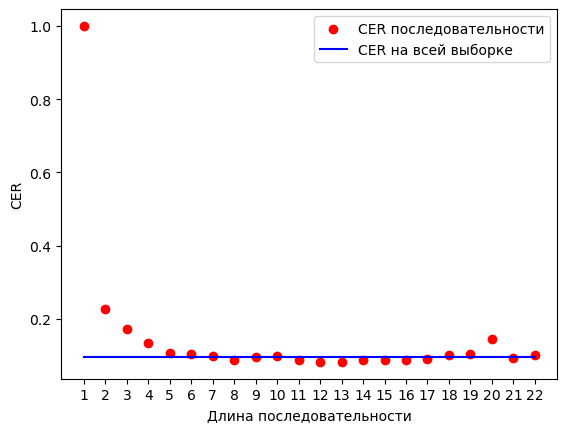

In [137]:
x = list(dict(sorted(stat[1].items())).keys())
y = dict(sorted(stat[1].items())).values()

plt.ylabel('CER')
plt.xlabel('Длина последовательности')
plt.xticks(x)
plt.scatter(x, y, color = 'red', label = 'CER последовательности')
plt.plot(x, [0.095 for i in x], color = 'blue', label = 'CER на всей выборке')
plt.legend(loc='best')